In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi)
ZERO = torch.tensor([0.]).to(device)
class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            ## ZERO = torch.tensor([0.]).to(device)
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1


In [13]:
def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    x_r: float
    right endpoint of an interval 
    Nx: int 
    number of subintervals for integration
    order: int
    order of Gauss Quadrature 
    Returns
    -------
    vectorized quadrature weights and integration points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)
    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)

def plot_solution_modified(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    x_model_pt = x_model_pt[x_model_pt>=r1].reshape(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,'-.',label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
    plt.plot(x_model_pt.cpu(),u_model_pt.cpu(),'.r')
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()

def Neumann_boundary_quadrature_points(M, dim):
    """
    the boundary is in dimension dim - 1. 
    If 1D problem, the boundary is 0D, the quadrature points are 0 and 1. 
    """
    if dim == 1: 
        weights_bd = torch.tensor([1.,1.]).view(-1,1).to(device)
        integration_points_bd = torch.tensor([0.,1.]).view(-1,1).to(device) 
    
    return weights_bd.to(device), integration_points_bd.to(device) 

def minimize_linear_layer_neumann(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N, activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    
    coef_func = 1 # 3 * model(integration_points).detach()**2 #changing after each newton iteration 
    jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

    # stiffness matrix 
    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:  
            basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
        else: 
            basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
    weighted_basis_value_dx_col = basis_value_dx_col * weights
    jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col 
    jac = jac1 + jac2

    rhs1 = weighted_basis_value_col.t() @ (target(integration_points) )

    # Neumman boundary condition
    basis_value_col_bd = F.relu(integration_points_bd @ w.t()+ b)**(model.k) 
    weighted_basis_value_col_bd = basis_value_col_bd *weights_bd 
    dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device) 
    rhs2 =  weighted_basis_value_col_bd.t() @ dudn

    rhs = rhs1 + rhs2 

#     print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
#     print("solving Ax = b time taken: ", time.time()-start_time)
    ## update the solution 
    return sol 

In [14]:
def show_convergence_order(err_l2,err_h10,exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.6f} \t\t * \t\t {:.6f} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex(err_l2,err_h10,exponent): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    print("neuron num  & \t $\|u-u_n \|_{L^2}$ & \t order & \t $ | u -u_n |_{H^1}$ & \t order \\\ \hline \hline ")
    for i, item in enumerate(err_list):
        if i == 0: 
            print("{} \t\t & {:.6f} &\t\t * & \t\t {:.6f} & \t\t *  \\\ \hline  \n".format(neuron_nums[i],item, err_list2[i] ) )   
        else: 
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} &  \t\t {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )


In [17]:

def relu_dict(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of dictionary elements 
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((2*N,2)).to(device)
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)  
    relu_dict_parameters[N:2*N,0] = -torch.ones(N)[:]
    relu_dict_parameters[N:2*N,1] = -torch.linspace(x_l,x_r,N+1)[1:] + 1/(2*N) # relu(-x - -bi) 
    
    return relu_dict_parameters

# relu dictionary
def relu_dict_MC(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
       number of dictionary elements  
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
    """
    # w = 1 
    random_value = torch.randint(0, 2, (N,)) * 2 - 1 # +1 or -1  
    relu_dict_parameters = torch.zeros((N,2)).to(device)
    relu_dict_parameters[:N,0] = random_value[:]
    relu_dict_parameters[:N,1] = (torch.rand(N)*(x_r-x_l) + x_l)*random_value # relu(x-bi) 

    return relu_dict_parameters

def select_greedy_neuron_ind(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd,k): 

    residual_values = - target(integration_points)
    if my_model!= None:
        residual_values +=  my_model(integration_points) 

    weight_func_values = residual_values*weights

    basis_values = (F.relu(relu_dict_parameters[:,0] *integration_points - relu_dict_parameters[:,1])**k).T # uses broadcasting

    output1 = torch.matmul(basis_values,weight_func_values) # 

    if k == 1:  
        dbasis_values_dx1 =  torch.heaviside(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1], ZERO) * relu_dict_parameters.t()[0:1,:]   
    else:  
        dbasis_values_dx1 = k * F.relu(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1])**(k-1) * relu_dict_parameters.t()[0:1,:] 

    weight_dbasis_values_dx1 =  dbasis_values_dx1 * weights
    
    # Neumann boundary condition 
    basis_values_bd_col = (F.relu(relu_dict_parameters[:,0] *integration_points_bd - relu_dict_parameters[:,1])**k) 
    weighted_basis_value_col_bd = basis_values_bd_col * weights_bd
    dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device)
    output3 =  weighted_basis_value_col_bd.t() @ dudn

    if my_model!= None:
        dmy_model_dx1 = my_model.evaluate_derivative(integration_points,1).detach()
        output2 = torch.matmul(weight_dbasis_values_dx1.t(), dmy_model_dx1) 
        output = torch.abs(output1 + output2 - output3)
    else:
        output = torch.abs(output1 - output3)
    neuron_index = torch.argmax(output.flatten())
    
    return neuron_index 

def OGANeumannReLU1D(my_model,target,u_exact,du_exact,g_N, N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1,rand_deter = 'deter', solver = 'direct'): 
    """ Orthogonal greedy algorithm to solve a 1D Neumann problem 1D ReLU dictionary over [0,1]
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r=1, Nx = Nx,order =order)
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(M = 2,dim = 1) 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1) 
    if my_model == None: 
        func_values = u_exact(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    if my_model!= None:
        err_h10[0] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5
    else: 
        err_h10[0] = torch.sum( du_exact(integration_points)**2*weights)**0.5
    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    if rand_deter == 'deter': 
        relu_dict_parameters = relu_dict(0,1,N).to(device) 
    for i in range(num_epochs): 
        print('epoch: ',i+1, end =' ')
        if rand_deter == 'rand': 
            relu_dict_parameters = relu_dict_MC(0,1,N).to(device)    
        # start_argmax = time.time() 
        neuron_index = select_greedy_neuron_ind(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd, k) 
        # print("argmax time: ", time.time() - start_argmax) 
        # print("selected neuron index: ",neuron_index,relu_dict_parameters[neuron_index,0],-relu_dict_parameters[neuron_index,1] ) 
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1]) # different sign convention 
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]

        sol = minimize_linear_layer_neumann(my_model,target,weights, integration_points,weights_bd, integration_points_bd,g_N,activation ='relu', solver = solver)
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]

        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(0,1,200).view(-1,1).to(device)
            u_true = u_exact(x_test)
            plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
        err_h10[i+1] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5 
    print("time taken: ",time.time() - start_time)
    return err, err_h10, my_model


using linear solver:  direct
epoch:  1 epoch:  2 epoch:  3 epoch:  4 epoch:  5 epoch:  6 epoch:  7 epoch:  8 epoch:  9 epoch:  10 epoch:  11 epoch:  12 epoch:  13 epoch:  14 epoch:  15 epoch:  16 epoch:  17 epoch:  18 epoch:  19 epoch:  20 epoch:  21 epoch:  22 epoch:  23 epoch:  24 epoch:  25 epoch:  26 epoch:  27 epoch:  28 epoch:  29 epoch:  30 epoch:  31 epoch:  32 epoch:  33 epoch:  34 epoch:  35 epoch:  36 epoch:  37 epoch:  38 epoch:  39 epoch:  40 epoch:  41 epoch:  42 epoch:  43 epoch:  44 epoch:  45 epoch:  46 epoch:  47 epoch:  48 epoch:  49 epoch:  50 epoch:  51 epoch:  52 epoch:  53 epoch:  54 epoch:  55 epoch:  56 epoch:  57 epoch:  58 epoch:  59 epoch:  60 epoch:  61 epoch:  62 epoch:  63 epoch:  64 epoch:  65 epoch:  66 epoch:  67 epoch:  68 epoch:  69 epoch:  70 epoch:  71 epoch:  72 epoch:  73 epoch:  74 epoch:  75 epoch:  76 epoch:  77 epoch:  78 epoch:  79 epoch:  80 epoch:  81 epoch:  82 epoch:  83 epoch:  84 epoch:  85 epoch:  86 epoch:  87 epoch:  88 epoch:  89 e

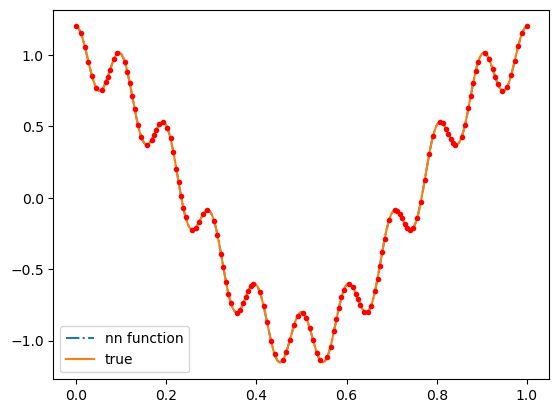

epoch:  129 epoch:  130 epoch:  131 epoch:  132 epoch:  133 epoch:  134 epoch:  135 epoch:  136 epoch:  137 epoch:  138 epoch:  139 epoch:  140 epoch:  141 epoch:  142 epoch:  143 epoch:  144 epoch:  145 epoch:  146 epoch:  147 epoch:  148 epoch:  149 epoch:  150 epoch:  151 epoch:  152 epoch:  153 epoch:  154 epoch:  155 epoch:  156 epoch:  157 epoch:  158 epoch:  159 epoch:  160 epoch:  161 epoch:  162 epoch:  163 epoch:  164 epoch:  165 epoch:  166 epoch:  167 epoch:  168 epoch:  169 epoch:  170 epoch:  171 epoch:  172 epoch:  173 epoch:  174 epoch:  175 epoch:  176 epoch:  177 epoch:  178 epoch:  179 epoch:  180 epoch:  181 epoch:  182 epoch:  183 epoch:  184 epoch:  185 epoch:  186 epoch:  187 epoch:  188 epoch:  189 epoch:  190 epoch:  191 epoch:  192 epoch:  193 epoch:  194 epoch:  195 epoch:  196 epoch:  197 epoch:  198 epoch:  199 epoch:  200 epoch:  201 epoch:  202 epoch:  203 epoch:  204 epoch:  205 epoch:  206 epoch:  207 epoch:  208 epoch:  209 epoch:  210 epoch:  211 epoc

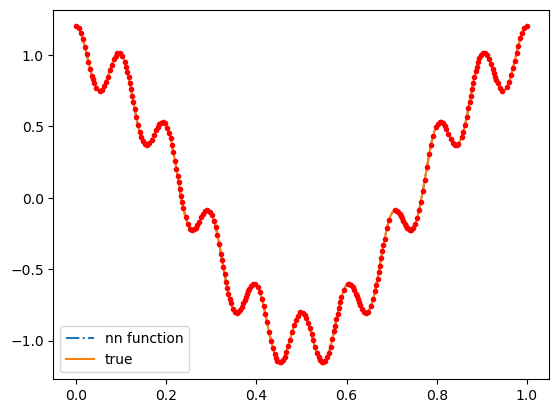

epoch:  257 epoch:  258 epoch:  259 epoch:  260 epoch:  261 epoch:  262 epoch:  263 epoch:  264 epoch:  265 epoch:  266 epoch:  267 epoch:  268 epoch:  269 epoch:  270 epoch:  271 epoch:  272 epoch:  273 epoch:  274 epoch:  275 epoch:  276 epoch:  277 epoch:  278 epoch:  279 epoch:  280 epoch:  281 epoch:  282 epoch:  283 epoch:  284 epoch:  285 epoch:  286 epoch:  287 epoch:  288 epoch:  289 epoch:  290 epoch:  291 epoch:  292 epoch:  293 epoch:  294 epoch:  295 epoch:  296 epoch:  297 epoch:  298 epoch:  299 epoch:  300 epoch:  301 epoch:  302 epoch:  303 epoch:  304 epoch:  305 epoch:  306 epoch:  307 epoch:  308 epoch:  309 epoch:  310 epoch:  311 epoch:  312 epoch:  313 epoch:  314 epoch:  315 epoch:  316 epoch:  317 epoch:  318 epoch:  319 epoch:  320 epoch:  321 epoch:  322 epoch:  323 epoch:  324 epoch:  325 epoch:  326 epoch:  327 epoch:  328 epoch:  329 epoch:  330 epoch:  331 epoch:  332 epoch:  333 epoch:  334 epoch:  335 epoch:  336 epoch:  337 epoch:  338 epoch:  339 epoc

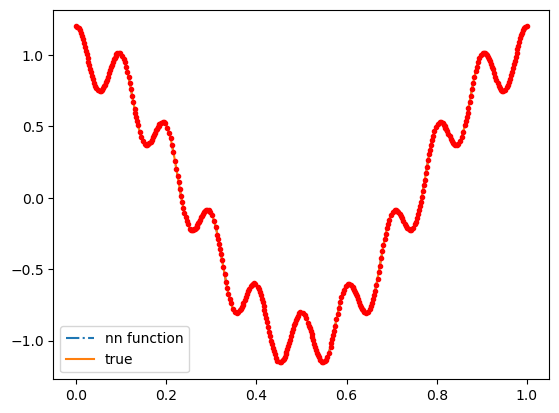

epoch:  385 epoch:  386 epoch:  387 epoch:  388 epoch:  389 epoch:  390 epoch:  391 epoch:  392 epoch:  393 epoch:  394 epoch:  395 epoch:  396 epoch:  397 epoch:  398 epoch:  399 epoch:  400 epoch:  401 epoch:  402 epoch:  403 epoch:  404 epoch:  405 epoch:  406 epoch:  407 epoch:  408 epoch:  409 epoch:  410 epoch:  411 epoch:  412 epoch:  413 epoch:  414 epoch:  415 epoch:  416 epoch:  417 epoch:  418 epoch:  419 epoch:  420 epoch:  421 epoch:  422 epoch:  423 epoch:  424 epoch:  425 epoch:  426 epoch:  427 epoch:  428 epoch:  429 epoch:  430 epoch:  431 epoch:  432 epoch:  433 epoch:  434 epoch:  435 epoch:  436 epoch:  437 epoch:  438 epoch:  439 epoch:  440 epoch:  441 epoch:  442 epoch:  443 epoch:  444 epoch:  445 epoch:  446 epoch:  447 epoch:  448 epoch:  449 epoch:  450 epoch:  451 epoch:  452 epoch:  453 epoch:  454 epoch:  455 epoch:  456 epoch:  457 epoch:  458 epoch:  459 epoch:  460 epoch:  461 epoch:  462 epoch:  463 epoch:  464 epoch:  465 epoch:  466 epoch:  467 epoc

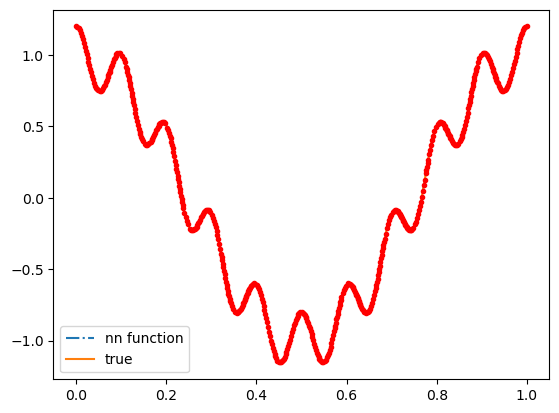

time taken:  12.6455979347229
neuron num 		 error 		 order
4 		 0.438680 		 * 		 8.846372 		 * 

8 		 0.146199 		 1.585236 		 8.418533 		 0.071517 

16 		 0.105597 		 0.469364 		 6.136849 		 0.456071 

32 		 0.008956 		 3.559516 		 1.268077 		 2.274856 

64 		 0.001815 		 2.302829 		 0.458902 		 1.466384 

128 		 0.000131 		 3.793840 		 0.081793 		 2.488140 

256 		 0.000017 		 2.921563 		 0.021950 		 1.897761 

512 		 0.000002 		 3.123814 		 0.005235 		 2.067830 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.438680 &		 * & 		 8.846372 & 		 *  \\ \hline  

8 		 &  1.462e-01 &  		 1.59 &  		 8.419e+00 &  		 0.07 \\ \hline  

16 		 &  1.056e-01 &  		 0.47 &  		 6.137e+00 &  		 0.46 \\ \hline  

32 		 &  8.956e-03 &  		 3.56 &  		 1.268e+00 &  		 2.27 \\ \hline  

64 		 &  1.815e-03 &  		 2.30 &  		 4.589e-01 &  		 1.47 \\ \hline  

128 		 &  1.309e-04 &  		 3.79 &  		 8.179e-02 &  		 2.49 \\ \hline  

256 		 &  1.727e-05 &  		 

In [18]:
def u_exact(x):
    return torch.cos(2*pi*x) + 0.2*torch.cos(10*2*pi*x)

def du_exact(x):
    return -2*pi*torch.sin(2*pi*x) - 4 *pi * torch.sin(10*2*pi*x)

def laplacian_u_exact(x):
    return -(2*pi)**2 * torch.cos(2*pi*x)  - 0.2 *(10*2*pi)**2 * torch.cos(10*2*pi*x) 

def rhs(x):
    return   -laplacian_u_exact(x) + u_exact(x)  

def g_N(x):
    return du_exact(x) 

function_name = "sine1d" 
filename_write = "1DRandCGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "w")
f_write.write("\n")
f_write.close() 

save = True 

for N in [2**12]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**13
    order = 2  
    exponent = 9
    num_epochs = 2**exponent  
    plot_freq = num_epochs//4
    rand_deter = 'deter' 
    err_QMC2, err_h10, my_model = OGANeumannReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =2, rand_deter = rand_deter,solver = "direct")
    
    if save: 
        folder = 'data_gd/'
        filename = folder + 'err_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data_gd/'
        filename = folder + 'model_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    
    show_convergence_order(err_QMC2,err_h10,exponent,2*N,filename_write,True)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)

    


\begin{array}{|c|c|c|c|c|}
\hline
\text{Neuron num} & \|u-u_n \|_{L^2} & \text{Order} & | u -u_n |_{H^1} & \text{Order} \\ \hline \hline 
4 & 0.438680 & * & 	8.846372 &  *  \\ \hline  
8 		 &  1.462e-01 &  		 1.59 &  		 8.419e+00 &  		 0.07 \\ \hline  
16 		 &  1.056e-01 &  		 0.47 &  		 6.137e+00 &  		 0.46 \\ \hline  
32 		 &  8.956e-03 &  		 3.56 &  		 1.268e+00 &  		 2.27 \\ \hline  
64 		 &  1.815e-03 &  		 2.30 &  		 4.589e-01 &  		 1.47 \\ \hline  
128 		 &  1.309e-04 &  		 3.79 &  		 8.179e-02 &  		 2.49 \\ \hline  
256 		 &  1.727e-05 &  		 2.92 &  		 2.195e-02 &  		 1.90 \\ \hline  
512 		 &  1.982e-06 &  		 3.12 &  		 5.235e-03 &  		 2.07 \\ \hline
\end{array}